In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "c"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
# Remove features to be dropped from previous notebook
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

31


In [5]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [6]:
with open(os.path.join("results", results_subfolder, "best_common_features.txt")) as f:
    best_common_features = json.load(f)

In [7]:
all_metrics = [
    "canberra", #best metric
    cd.clark
]

In [8]:
from IPython.display import display, HTML

filepath1 = os.path.join(
    "results",
    results_subfolder,
    "distclassipy",
    "clark",
    "sfs_best_confusion_matrix.pdf",
)
filepath2 = os.path.join(
    "results",
    results_subfolder,
    "distclassipy",
    "canberra",
    "sfs_best_confusion_matrix.pdf",
)

html_str = f"""
<div style='width: 100%; display: flex;'>
    <iframe src='{filepath1}' width='50%' height='500'></iframe>
    <iframe src='{filepath2}' width='50%' height='500'></iframe>
</div>
"""

In [9]:
table1 = {
    'DSCT': 16709,
    'RR': 32518,
    'CEP': 1610,
    'RRc': 13875
}
total = sum(table1.values())
table1_ratio = {key: value / total for key, value in table1.items()}
max_ratio = max(table1_ratio.values())
sample_sizes = {key: int(494*value / max_ratio) for key, value in table1_ratio.items()}
sample_sizes

{'DSCT': 253, 'RR': 494, 'CEP': 24, 'RRc': 210}

  0%|          | 0/2 [00:00<?, ?it/s]

Canberra
	Expected Score from training:
		F1 = 91.22 ± 1.38%
	Actual score on hidden set:
		F1 = 93.13 %


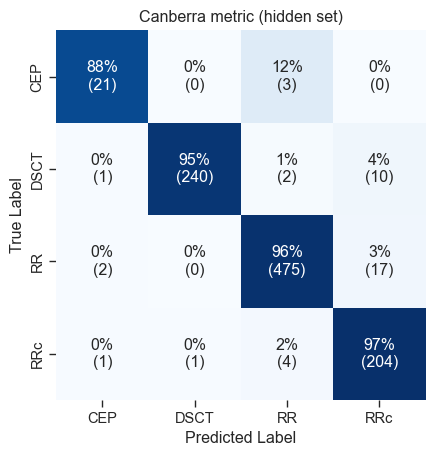

Clark
	Expected Score from training:
		F1 = 91.99 ± 0.61%
	Actual score on hidden set:
		F1 = 86.44 %


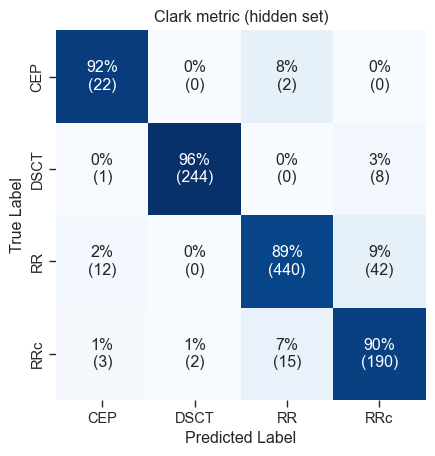

In [10]:
for metric in tqdm(all_metrics):
    metric_str = utils.get_metric_name(metric)
    locpath = os.path.join("results", results_subfolder, "distclassipy", metric_str)
    print(f"{metric_str.title()}")

    sfs_df = pd.read_csv(os.path.join(locpath, "sfs_allfeatures.csv"), index_col=0)
    feats_idx, feats = utils.load_best_features(sfs_df)

    lcdc = dcpy.DistanceMetricClassifier(
        metric=metric, scale_std=True, calculate_kde=False, calculate_1d_dist=False
    )

    X_df = X_df_FULL.loc[y_df.index]

    X_df = X_df.loc[:, feats]

    X = X_df.to_numpy()
    y = y_df.to_numpy().ravel()

    lcdc.fit(X, y)

    HIDDENX_df = pd.read_csv("data/HIDDENX_df_multiclass.csv", index_col=0)
    HIDDENX_df = HIDDENX_df.loc[:,X_df.columns]
    HIDDENX_df = HIDDENX_df.dropna()
    
    
    HIDDENy_df = pd.read_csv("data/HIDDENy_df_multiclass.csv", index_col=0)
    HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]
    
    
    # RESAMPLE TO BE OF RATIO OF REAL WORLD
    HIDDENy_df_resampled = []
    for cl, subdf in HIDDENy_df.groupby('class'):
        HIDDENy_df_resampled.append(
            subdf.sample(
                n=sample_sizes[cl], 
                random_state=settings_dict['seed_choice']
            )
        )
    
    HIDDENy_df = pd.concat(HIDDENy_df_resampled).sample(frac=1,random_state=settings_dict['seed_choice'])
    HIDDENX_df = HIDDENX_df.loc[HIDDENy_df.index]
    HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]

    HIDDENX_df = HIDDENX_df.loc[:, feats]
    HIDDENX_df = HIDDENX_df.dropna()
    HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]

    HIDDENX = HIDDENX_df.to_numpy()
    HIDDENy = HIDDENy_df.to_numpy().ravel()

    HIDDENy_pred = lcdc.predict_and_analyse(HIDDENX)

    acc = accuracy_score(y_true=HIDDENy, y_pred=HIDDENy_pred)
    f1score = f1_score(y_true=HIDDENy, y_pred=HIDDENy_pred, average="macro")
    matthew_coef = matthews_corrcoef(y_true=HIDDENy, y_pred=HIDDENy_pred)

    print("\tExpected Score from training:")
    print(
        f"\t\tF1 = {sfs_df.loc[len(feats)]['avg_score']*100:.2f} ± {sfs_df.loc[len(feats)]['std_dev']*100:.2f}%"
    )
    print("\tActual score on hidden set:")
    # print(f"\tAcc = {100*acc:.2f} %")
    print(f"\t\tF1 = {100*f1score:.2f} %")

    ax = utils.plot_cm(y_true=HIDDENy, y_pred=HIDDENy_pred)
    plt.title(f"{metric_str.title()} metric (hidden set)")
    plt.savefig(os.path.join(locpath, "hidden_cm.pdf"), bbox_inches="tight")
    # plt.savefig(f"hidden_cm/{metric_str}.pdf",bbox_inches = 'tight')
    plt.show()

In [11]:
HIDDENy_df.value_counts()

class
RR       494
DSCT     253
RRc      210
CEP       24
Name: count, dtype: int64

In [12]:
display(HTML(html_str))

In [13]:
HIDDENy_df.value_counts()

class
RR       494
DSCT     253
RRc      210
CEP       24
Name: count, dtype: int64

In [14]:
HIDDENy_df

,class
oid,
519864,DSCT
63902,DSCT
190237,RRc
278302,RR
331707,RRc
...,...
574583,RR
394901,DSCT
196797,RR
